<a href="https://colab.research.google.com/github/allan-jt/IJEPA-Thermal-Benchmark/blob/main/ijepa_no_layer_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries



In [1]:
!pip install --upgrade transformers

In [2]:
import requests
from PIL import Image
from torch.nn.functional import cosine_similarity
from transformers import AutoModel, AutoProcessor
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [4]:
model_id = "facebook/ijepa_vith14_1k"
batch_size = 32

# Data Loader

In [5]:
import kagglehub
path = kagglehub.dataset_download("breejeshdhar/thermal-image-dataset-for-object-classification")

100%|██████████| 3.24G/3.24G [00:43<00:00, 79.5MB/s]

Extracting files...


In [6]:
import os
!mv {path} {os.getcwd()}

In [7]:
# In Train set, switch the content of Car and Cat since
# the images belong to the other category
train_dir = "/content/1/Thermal Image Dataset/SeekThermal/Train"
car_folder = os.path.join(train_dir, "Car")
cat_folder = os.path.join(train_dir, "Cat")
temp_folder = os.path.join(train_dir, "TempFolder")

os.rename(car_folder, temp_folder)  # Rename "Car" to "TempFolder"
os.rename(cat_folder, car_folder)  # Rename "Cat" to "Car"
os.rename(temp_folder, cat_folder)  # Rename "TempFolder" to "Cat"

# In Test set, capitalise the folder names
test_dir = "/content/1/Thermal Image Dataset/SeekThermal/Test"
car_folder = os.path.join(test_dir, "car")
cat_folder = os.path.join(test_dir, "cat")
man_folder = os.path.join(test_dir, "man")

Car_folder = os.path.join(test_dir, "Car")
Cat_folder = os.path.join(test_dir, "Cat")
Man_folder = os.path.join(test_dir, "Man")

os.rename(car_folder, Car_folder)
os.rename(cat_folder, Cat_folder)
os.rename(man_folder, Man_folder)

In [8]:
# Remove test data from train data folder

# Subdirectories
categories = ["Cat", "Car", "Man"]

for category in categories:
    # Paths for the current category in Train and Test
    train_path = os.path.join(train_dir, category)
    test_path = os.path.join(test_dir, category)

    # Get list of files in Train and Test directories
    train_files = set(os.listdir(train_path))
    test_files = set(os.listdir(test_path))

    # Find overlapping files
    overlapping_files = train_files & test_files

    # Remove overlapping files from Train directory
    for file in overlapping_files:
        file_path = os.path.join(train_path, file)
        os.remove(file_path)

print("Cleanup complete!")


Cleanup complete!


In [9]:
# Count the number of images we have in each class in the training data

def count_only_files(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

def get_file_count():
  min_file_count = 10000
  class_to_img_count = dict()
  for c in categories:
    folder_path = os.path.join(train_dir, c)
    file_count = count_only_files(folder_path)
    if file_count < min_file_count:
      min_file_count = file_count
    class_to_img_count[c] = file_count
  return min_file_count, class_to_img_count

# Count number of images in the train data for each class
min_img_count, class_to_img_count = get_file_count()
print(f'Mininum file count: {min_img_count}')
for k, v in class_to_img_count.items():
  print(f'{k} : {v} images')

Mininum file count: 1048
Cat : 1048 images
Car : 1426 images
Man : 1426 images


In [10]:
# Balance training data if needed by removing images from classes with more images

import random
def remove_random_files(folder_path, num_files_to_remove):
    # Get the list of all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Check if there are enough files to remove
    if num_files_to_remove > len(files):
        print("Error: Number of files to remove exceeds the number of files in the folder.")
        return

    # Randomly select files to remove
    files_to_remove = random.sample(files, num_files_to_remove)

    # Remove the selected files
    for file_name in files_to_remove:
        file_path = os.path.join(folder_path, file_name)
        os.remove(file_path)

    print(f"Removed {len(files_to_remove)} images from {folder_path}")

# Remove images from a class to make the dataset more balanced
for c in categories:
  folder_path = os.path.join(train_dir, c)
  num_files_to_remove = class_to_img_count[c] - min_img_count
  if (num_files_to_remove > 0):
    remove_random_files(folder_path, num_files_to_remove)

Removed 378 images from /content/1/Thermal Image Dataset/SeekThermal/Train/Car
Removed 378 images from /content/1/Thermal Image Dataset/SeekThermal/Train/Man


In [11]:
# check that the training data is balanced

min_img_count, class_to_img_count = get_file_count()
print(f'Mininum file count: {min_img_count}')
for k, v in class_to_img_count.items():
  print(f'{k} : {v} images')

Mininum file count: 1048
Cat : 1048 images
Car : 1048 images
Man : 1048 images


In [12]:
# def fix_exif_orientation(image):
#     return ImageOps.exif_transpose(image)

processor = AutoProcessor.from_pretrained(model_id)
transform = transforms.Compose([
    transforms.Lambda(lambda img: ImageOps.exif_transpose(img)),  # Fix EXIF orientation
    transforms.Lambda(lambda img: processor(img, return_tensors="pt")["pixel_values"].squeeze(0))  # Apply processor
])


# transform = transforms.Compose([
#     transforms.Lambda(fix_exif_orientation),
#     transforms.Resize((400, 300)),  # Resize images
#     transforms.ToTensor(),          # Convert to tensor
# ])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
# Load the dataset
# The test and train folder should follow their orginal structure where there are 3 subfolders, one for each class
train_dataset = datasets.ImageFolder(root='/content/1/Thermal Image Dataset/SeekThermal/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/1/Thermal Image Dataset/SeekThermal/Test', transform=transform)

In [14]:
# Define split ratios
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

# Split the dataset
torch.manual_seed(42)  # Set seed for reproducibility
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [15]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [16]:
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Testing data size: {len(test_dataset)}")
print(train_dataset.class_to_idx)

Train data size: 2515
Validation data size: 629
Testing data size: 1068
{'Car': 0, 'Cat': 1, 'Man': 2}


In [17]:
# Verify a batch from train_loader
from PIL import Image, ImageOps
from IPython.display import display
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")  # Example: [32, 3, 300, 400]
    print(f"Batch labels: {labels}")            # Example: tensor([0, 1, ...])
    print(images[0])
    print(labels[0])
    break

Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([0, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 1, 2, 0, 1,
        2, 1, 0, 0, 1, 2, 2, 0])
tensor([[[ 0.9922,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9922,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ...,  0.9922,  1.0000,  1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0.9922,  1.0000,  1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  1.0000,  0.9922,  1.0000]],

        [[ 0.9922,  0.9922,  0.9922,  ...,  0.4980,  0.4980,  0.4980],
         [ 0.9843,  0.9843,  0.9843,  ...,  0.4980,  0.4980,  0.4980],
         [ 0.9608,  0.9608,  0.9608,  ...,  0.4980,  0.4980,  0.4980],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.8353, -0.7333, -0.6471],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9216, -0.8745, -0.8118],
         [-1.

# Loading Backbone

In [18]:
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ClassificationHead, self).__init__()

        self.model = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.model(x)

In [19]:
class BackboneWithClassificationHead(nn.Module):
    def __init__(self, backbone, output_dim, withBatchNorm=False):
        super(BackboneWithClassificationHead, self).__init__()
        self.backbone = backbone
        self.backbone.requires_grad_(False)
        self.batch_norm = None
        if withBatchNorm:
            self.batch_norm = nn.BatchNorm1d(self.backbone.config.hidden_size)
        self.classification_head = ClassificationHead(
            self.backbone.config.hidden_size,
            output_dim,
        )
        self.classification_head.requires_grad_(True)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values)
        cls_token = outputs.last_hidden_state.mean(dim=1)
        if self.batch_norm is not None:
          cls_token = self.batch_norm(cls_token)
        return self.classification_head(cls_token)

# Set up Trainer

In [20]:
backbone = AutoModel.from_pretrained(model_id)

In [21]:
model = BackboneWithClassificationHead(
    backbone,
    3,
)

In [22]:
import torch.optim as optim
from tqdm import tqdm

In [23]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return epoch_loss / len(dataloader), accuracy

In [24]:
def evaluate_epoch(model, dataloader, criterion, device):
    model.eval()
    epoch_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return epoch_loss / len(dataloader), accuracy

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Training parameters
num_epochs = 20
best_accuracy = 0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss, train_accuracy = train_epoch(
        model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Evaluate
    val_loss, val_accuracy = evaluate_epoch(
        model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


    # Save the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")

print(f"Training complete. Best Validation Accuracy: {best_accuracy:.2f}%")

Epoch 1/20


Training: 100%|██████████| 79/79 [03:35<00:00,  2.73s/it]


Training Loss: 1.0335, Training Accuracy: 56.26%


Evaluating: 100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


Validation Loss: 0.9163, Validation Accuracy: 76.79%
Best model saved!
Epoch 2/20


Training: 100%|██████████| 79/79 [03:47<00:00,  2.88s/it]


Training Loss: 0.8380, Training Accuracy: 80.44%


Evaluating: 100%|██████████| 20/20 [00:57<00:00,  2.90s/it]


Validation Loss: 0.7518, Validation Accuracy: 84.42%
Best model saved!
Epoch 3/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.90s/it]


Training Loss: 0.7075, Training Accuracy: 84.53%


Evaluating: 100%|██████████| 20/20 [00:57<00:00,  2.90s/it]


Validation Loss: 0.6415, Validation Accuracy: 86.01%
Best model saved!
Epoch 4/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.91s/it]


Training Loss: 0.6173, Training Accuracy: 86.08%


Evaluating: 100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


Validation Loss: 0.5626, Validation Accuracy: 86.49%
Best model saved!
Epoch 5/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.90s/it]


Training Loss: 0.5493, Training Accuracy: 87.79%


Evaluating: 100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


Validation Loss: 0.5048, Validation Accuracy: 89.03%
Best model saved!
Epoch 6/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.90s/it]


Training Loss: 0.4994, Training Accuracy: 88.79%


Evaluating: 100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


Validation Loss: 0.4595, Validation Accuracy: 89.67%
Best model saved!
Epoch 7/20


Training: 100%|██████████| 79/79 [03:44<00:00,  2.85s/it]


Training Loss: 0.4593, Training Accuracy: 89.46%


Evaluating: 100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


Validation Loss: 0.4240, Validation Accuracy: 90.94%
Best model saved!
Epoch 8/20


Training: 100%|██████████| 79/79 [03:45<00:00,  2.85s/it]


Training Loss: 0.4265, Training Accuracy: 90.22%


Evaluating: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


Validation Loss: 0.3945, Validation Accuracy: 91.73%
Best model saved!
Epoch 9/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.91s/it]


Training Loss: 0.3999, Training Accuracy: 91.09%


Evaluating: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


Validation Loss: 0.3696, Validation Accuracy: 92.21%
Best model saved!
Epoch 10/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.91s/it]


Training Loss: 0.3757, Training Accuracy: 91.73%


Evaluating: 100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


Validation Loss: 0.3485, Validation Accuracy: 92.21%
Epoch 11/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.91s/it]


Training Loss: 0.3572, Training Accuracy: 92.13%


Evaluating: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


Validation Loss: 0.3299, Validation Accuracy: 92.69%
Best model saved!
Epoch 12/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.90s/it]


Training Loss: 0.3383, Training Accuracy: 92.29%


Evaluating: 100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


Validation Loss: 0.3162, Validation Accuracy: 92.69%
Epoch 13/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.91s/it]


Training Loss: 0.3243, Training Accuracy: 92.45%


Evaluating: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


Validation Loss: 0.3013, Validation Accuracy: 93.16%
Best model saved!
Epoch 14/20


Training: 100%|██████████| 79/79 [03:45<00:00,  2.85s/it]


Training Loss: 0.3106, Training Accuracy: 92.56%


Evaluating: 100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


Validation Loss: 0.2898, Validation Accuracy: 93.80%
Best model saved!
Epoch 15/20


Training: 100%|██████████| 79/79 [03:48<00:00,  2.90s/it]


Training Loss: 0.2988, Training Accuracy: 92.64%


Evaluating: 100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


Validation Loss: 0.2779, Validation Accuracy: 94.28%
Best model saved!
Epoch 16/20


Training: 100%|██████████| 79/79 [03:48<00:00,  2.89s/it]


Training Loss: 0.2875, Training Accuracy: 92.92%


Evaluating: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


Validation Loss: 0.2677, Validation Accuracy: 94.28%
Epoch 17/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.91s/it]


Training Loss: 0.2782, Training Accuracy: 92.88%


Evaluating: 100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


Validation Loss: 0.2585, Validation Accuracy: 93.96%
Epoch 18/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.91s/it]


Training Loss: 0.2706, Training Accuracy: 93.00%


Evaluating: 100%|██████████| 20/20 [00:57<00:00,  2.90s/it]


Validation Loss: 0.2507, Validation Accuracy: 94.59%
Best model saved!
Epoch 19/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.90s/it]


Training Loss: 0.2612, Training Accuracy: 93.36%


Evaluating: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


Validation Loss: 0.2471, Validation Accuracy: 94.59%
Epoch 20/20


Training: 100%|██████████| 79/79 [03:49<00:00,  2.90s/it]


Training Loss: 0.2538, Training Accuracy: 93.60%


Evaluating: 100%|██████████| 20/20 [00:57<00:00,  2.90s/it]


Validation Loss: 0.2362, Validation Accuracy: 94.91%
Best model saved!
Training complete. Best Validation Accuracy: 94.91%


# Results

In [26]:
# Test set
best_model_path = "best_model.pth"
model.load_state_dict(torch.load(best_model_path, weights_only=True))
test_loss, test_accuracy = evaluate_epoch(
        model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Evaluating: 100%|██████████| 34/34 [01:37<00:00,  2.86s/it]

Test Loss: 0.2551, Test Accuracy: 91.76%


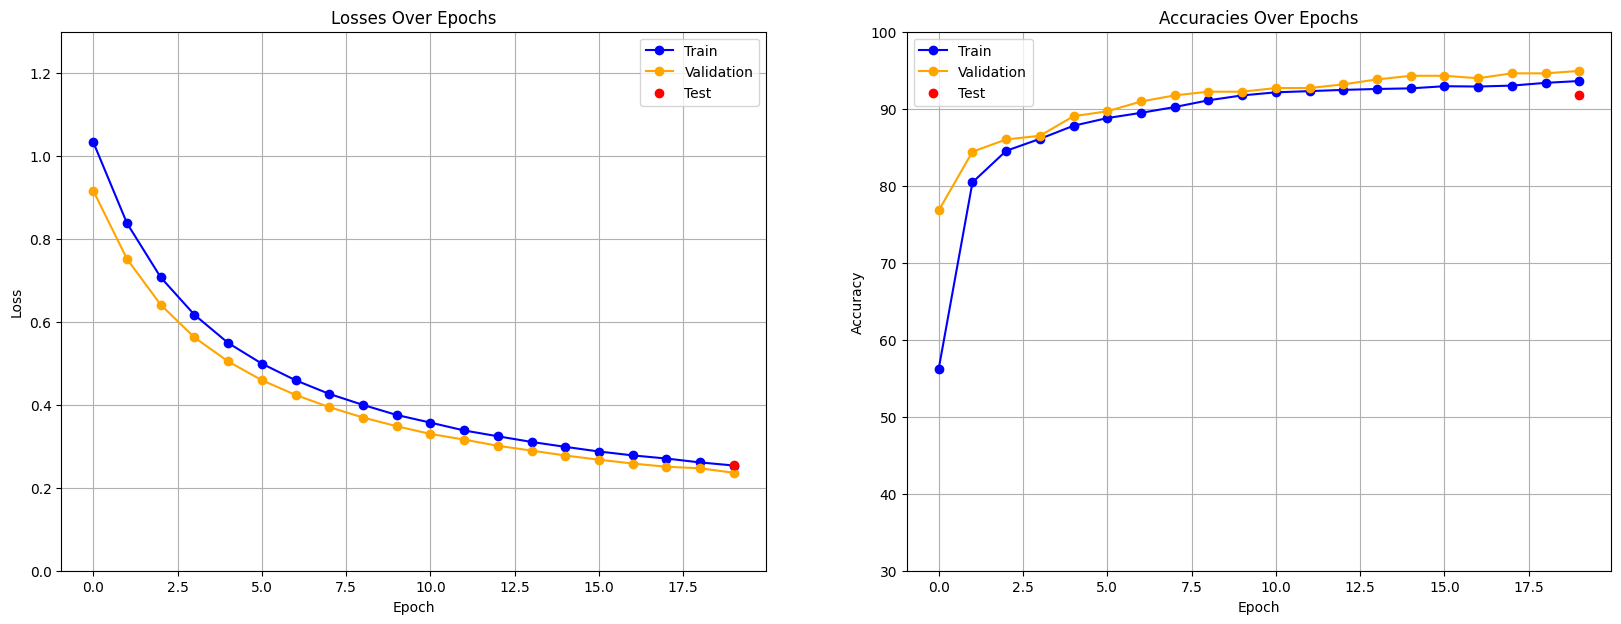

In [27]:
plt.figure(figsize=(20, 7))  # Adjust the size of the plot

# Plot for Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train', marker='o', color='blue')
plt.plot(val_losses, label='Validation', marker='o', color='orange')
plt.scatter([best_epoch], [test_loss], color='red', label='Test', zorder=5)
plt.title('Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.3)


# Plot for Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train', marker='o', color='blue')
plt.plot(val_accuracies, label='Validation', marker='o', color='orange')
plt.scatter([best_epoch], [test_accuracy], color='red', label='Test', zorder=5)
plt.title('Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(30, 100)

plt.show()